# MMM Analysis & Simulation Notebook
Python 3.10  |  PyMC 5.x


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from pathlib import Path
import japanize_matplotlib
from functools import cache
import plotly_express as px
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az
from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter
from meridian.analysis.analyzer import DataTensors
import os
file_path = os.getcwd()
plt.style.use('ggplot')


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


## データ読み込み & ヘッダ整形

In [2]:

file_path = Path("（生茶）ATL_入力フォーマット_0206_TV情報付加.xlsx")
sheet_name = "Sheet1"

df_raw = pd.read_excel(file_path, sheet_name=sheet_name, engine="openpyxl")
# df["週"] = pd.to_datetime(df["週"])
df_raw.head()

,週,イベント,"推計販売規模 (金額) x1/1,000","推計販売規模 (本数 （数量×入数）) x1/1,000",TV_GRP,TV_費用,OOH_費用,雑誌/新聞（純広）_費用,記事広告_費用,ラジオ_視聴率,...,OTT_費用,Scaleout_imp,Scaleout_click数,Scaleout_費用,TTD_imp,TTD_click数,TTD_費用,AmazonDSP_imp,AmazonDSP_click数,AmazonDSP_費用
0,2021-09-13,生茶ほうじ煎茶,647922,6498,1080.7,135087500.0,22338000.0,NaN,6421836.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-20,NaN,599978,6419,646.1,80762500.0,20987000.0,NaN,7492142.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-09-27,NaN,488095,5340,84.4,10550000.0,NaN,NaN,1070306.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-10-04,NaN,657360,6562,40.8,5100000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-10-11,NP,827713,7655,1089.9,136237500.0,10500000.0,15000000.0,2500000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 欠損率可視化

In [3]:
# 各変数の欠損値を確認
df_tmp = df_raw.isna().mean().sort_values(ascending=False).reset_index()
df_tmp.columns = ["変数名", "欠損率"]
px.bar(df_tmp, x="変数名", y="欠損率")

# TVは欠損値ほぼ無しだが、他は欠損値多し。欠損期間は0で埋めるとともに、ある程度メディアでまとめる必要がある。

## 目的変数の推移

In [4]:
TARGET_COL = "推計販売規模 (本数 （数量×入数）) x1/1,000"
px.line(df_raw, x="週", y=TARGET_COL)


In [5]:
df_raw["平均単価"] = df_raw["推計販売規模 (金額) x1/1,000"]/df_raw["推計販売規模 (本数 （数量×入数）) x1/1,000"]
px.line(df_raw, x="週", y="平均単価")

In [44]:
# メディアの変数をまとめていく
## まとめる必要がないものはそのまま入れて、0で埋める。
df_conv = df_raw[["週", '推計販売規模 (金額) x1/1,000', "推計販売規模 (本数 （数量×入数）) x1/1,000", "TV_GRP", "TV_費用", "OOH_費用"]].fillna(0).rename(
    columns={
        "週":"week", '推計販売規模 (金額) x1/1,000':"売上金額", "推計販売規模 (本数 （数量×入数）) x1/1,000":"売上数量", 
        "TV_費用":"TV_spend", "OOH_費用":"OOH_spend"}
)

## デジタルは費用、imp、click数でまとめる
tgt_list = ["Youtube_費用", "Twitter_費用", "FB/IG_費用", "Yahoo!_費用", "LINE_費用", "Tiktok_費用", "OTT_費用", "Scaleout_費用", "TTD_費用", "AmazonDSP_費用"]
df_conv["digital_spend"] = df_raw[tgt_list].fillna(0).sum(axis=1)

tgt_list = ["Youtube_再生開始数", "Twitter_imp", "FB/IG_imp", "Yahoo!_imp", "LINE_imp", "Tiktok_imp", "OTT_imp", "Scaleout_imp", "TTD_imp", "AmazonDSP_imp"]
df_conv["digital_imp"] = df_raw[tgt_list].fillna(0).sum(axis=1)

### "AmazonDSP_click数"は欠損値のみのため、個々には含まない
tgt_list = ["Youtube_click数", "Twitter_click数", "FB/IG_click数", "Yahoo!_click数", "LINE_click数", "Tiktok_click数", "Scaleout_click数", "TTD_click数"]
df_conv["digital_click"] = df_raw[tgt_list].fillna(0).sum(axis=1)

## その他は費用でまとめる
tgt_list = ["雑誌/新聞（純広）_費用", "記事広告_費用", "ラジオ_費用"]
df_conv["othermedia_spend"] = df_raw[tgt_list].fillna(0).sum(axis=1)

# 元の単位に戻す
df_conv["売上金額"] = df_conv["売上金額"]*1000
df_conv["売上数量"] = df_conv["売上数量"]*1000
df_conv.head()

,week,売上金額,売上数量,TV_GRP,TV_spend,OOH_spend,digital_spend,digital_imp,digital_click,othermedia_spend
0,2021-09-13,647922000,6498000,1080.7,135087500.0,22338000.0,2.911718e+07,2.761625e+07,68538.501838,6421836.0
1,2021-09-20,599978000,6419000,646.1,80762500.0,20987000.0,2.668432e+07,1.930929e+07,35151.715861,7492142.0
2,2021-09-27,488095000,5340000,84.4,10550000.0,0.0,3.138576e+06,2.460621e+06,1088.785977,1070306.0
3,2021-10-04,657360000,6562000,40.8,5100000.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.0
4,2021-10-11,827713000,7655000,1089.9,136237500.0,10500000.0,2.487627e+07,4.359253e+07,93520.000000,17500000.0


### 相関行列ヒートマップ

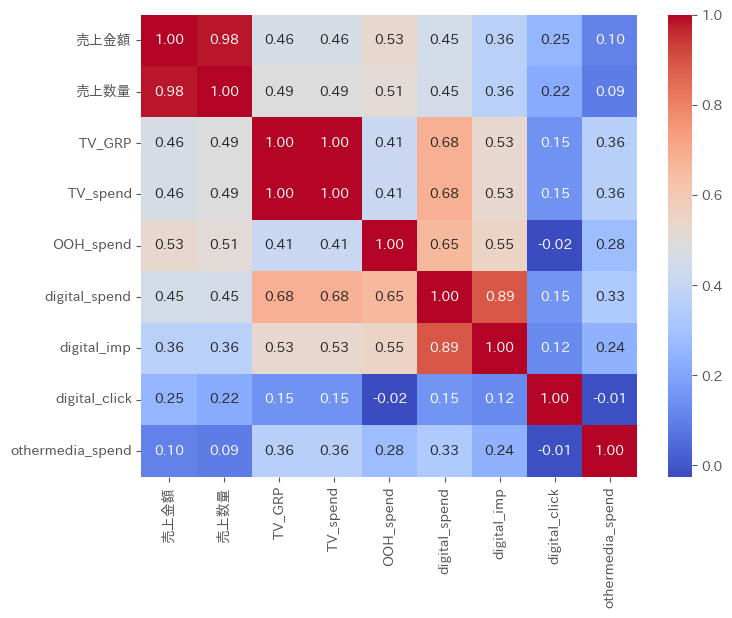

In [45]:
# TV,OOH,デジタルの費用やimpとの相関が高め。
corr_cols = [
    '売上金額','売上数量', 'TV_GRP', 'TV_spend', 'OOH_spend', 'digital_spend',
    'digital_imp', 'digital_click', 'othermedia_spend'
]
corr = df_conv[corr_cols].fillna(0).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


## データの設定

In [46]:
from meridian.data import data_frame_input_data_builder as data_builder
df = df_conv

builder = (
    data_builder.DataFrameInputDataBuilder(kpi_type='revenue')
        .with_kpi(df, kpi_col="売上金額", time_col="week")
        .with_media(
            df,
            time_col="week",
            media_cols=["TV_GRP", "OOH_spend", "digital_imp", "othermedia_spend"],
            media_spend_cols=["TV_spend", "OOH_spend", "digital_spend", "othermedia_spend"],
            media_channels=["TV", "OOH", "digital", "othermedia"]
            )
)

data = builder.build()

c:\Users\BR18126\mmm\Lib\site-packages\meridian\data\input_data.py:463: UserWarning:

Revenue from the `kpi` data is used when `kpi_type`=`revenue`. `revenue_per_kpi` is ignored.



## モデル設計

In [ ]:
# 事前分布を設定する
import tensorflow_probability as tfp
from meridian import constants
from meridian.model import prior_distribution, spec, model

media_channels = ["TV", "OOH", "digital", "othermedia"]
roi_prior_dict = {
    "TV":         (0.30, 0.70),
    "OOH":        (0.20, 0.80),
    "digital":    (0.35, 0.60),
    "othermedia": (0.25, 0.75),
}
roi_mu, roi_sigma = zip(*(roi_prior_dict[ch] for ch in media_channels))

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(
        roi_mu, roi_sigma, name=constants.ROI_M
    )
)
# 期間のholdout
np.random.seed(1)
test_pct = 0.1  # 20% of data are held out
n_times = len(data.time)
holdout_id = np.full(n_times, False)
test_idx = np.random.choice(n_times, int(np.round(test_pct * n_times)), replace=False)
holdout_id[test_idx] = True 

model_spec = spec.ModelSpec(prior=prior, max_lag=4, media_prior_type="roi", holdout_id=holdout_id)

In [48]:
meridian = model.Meridian(input_data=data, model_spec=model_spec)
meridian.sample_prior(500)
meridian.sample_posterior(n_chains=4, n_adapt=2000, n_burnin=2000, n_keep=1000, seed=42)

c:\Users\BR18126\mmm\Lib\site-packages\meridian\model\model.py:66: UserWarning:

In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.

c:\Users\BR18126\mmm\Lib\site-packages\meridian\model\prior_distribution.py:912: UserWarning:

Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).

c:\Users\BR18126\mmm\Lib\site-packages\meridian\model\prior_distribution.py:912: UserWarning:

Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).

c:\Users\BR18126\mmm\Lib\site-packages\meridian\model\prior_distribution.py:912: UserWarning:

Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).

c:\Users\BR18126\mmm\Lib\site-packages\meridian\model\prior_distribution.py:912: UserWarning:

Hiera

# モデルの結果

In [49]:
model_diagnostics = visualizer.ModelDiagnostics(meridian)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

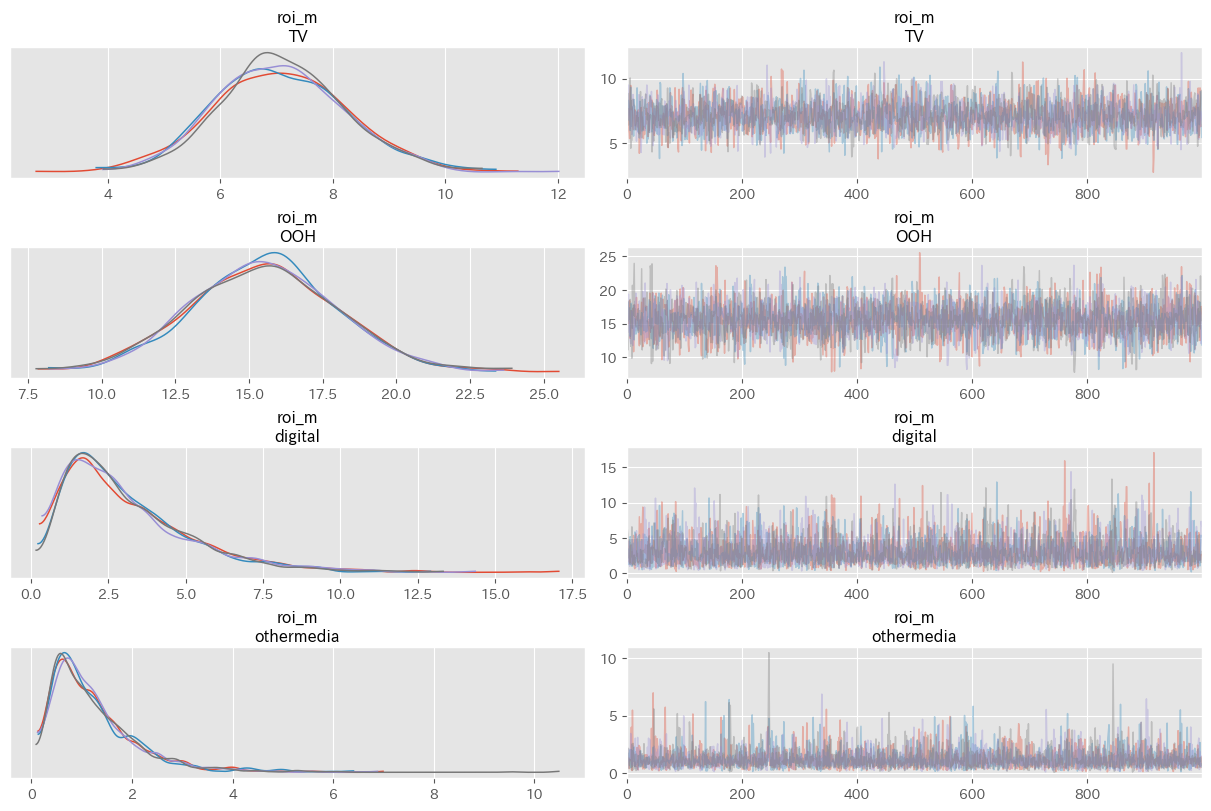

In [50]:
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      meridian.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )

In [51]:
model_diagnostics = visualizer.ModelDiagnostics(meridian)
model_diagnostics.plot_prior_and_posterior_distribution()

alt.FacetChart(...)

In [53]:
model_diagnostics = visualizer.ModelDiagnostics(meridian)
model_diagnostics.predictive_accuracy_table()

c:\Users\BR18126\mmm\Lib\site-packages\meridian\analysis\analyzer.py:556: UserWarning:

The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.



,metric,geo_granularity,evaluation_set,value
0,R_Squared,national,Train,0.531945
1,R_Squared,national,Test,0.423532
2,R_Squared,national,All Data,0.518796
3,MAPE,national,Train,0.165928
4,MAPE,national,Test,0.229255
5,MAPE,national,All Data,0.172130
6,wMAPE,national,Train,0.166361
7,wMAPE,national,Test,0.227859
8,wMAPE,national,All Data,0.172488


In [54]:
model_fit = visualizer.ModelFit(meridian)
model_fit.plot_model_fit()

c:\Users\BR18126\mmm\Lib\site-packages\meridian\analysis\analyzer.py:556: UserWarning:

The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.



alt.LayerChart(...)

In [70]:
media_effects = visualizer.MediaEffects(meridian)
media_effects.plot_response_curves()

alt.FacetChart(...)

In [65]:
media_effects.plot_adstock_decay()

alt.FacetChart(...)

In [ ]:
# サマリの作成
mmm_summarizer = summarizer.Summarizer(meridian)
start_date = '2021-09-13'
end_date = '2025-05-26'
mmm_summarizer.output_model_results_summary('summary_output.html', file_path, start_date, end_date)

c:\Users\BR18126\mmm\Lib\site-packages\meridian\analysis\analyzer.py:556: UserWarning:

The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.

c:\Users\BR18126\mmm\Lib\site-packages\meridian\analysis\analyzer.py:556: UserWarning:

The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.

c:\Users\BR18126\mmm\Lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning:

invalid value encountered in subtract

c:\Users\BR18126\mmm\Lib\site-packages\meridian\analysis\analyzer.py:3069: UserWarning:

Effectiveness is not reported because it does not have a clear interpretation by time period.

c:\Users\BR18126\mmm\Lib\site-packages\meridian\analysis\analyzer.py:855: UserWarning:

Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.

c:\Users\BR18126\mmm\Lib\site-packages\tensorflow\python\autograph\impl\api.py:371: UserWarning:

Setting `use_kpi=True` has 